Загрузка всех необходимых модулей

In [ ]:
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
from scipy.ndimage.filters import gaussian_filter1d
from PIL import Image, ImageOps
from torch import Tensor
import matplotlib.patches as patches

In [ ]:
class CNN(Module):
  #на вход принимает количество каналов
  def __init__(self, n_channels):
    super().__init__()
    self.hidden1 = Conv2d(n_channels, 32, (3,3))
    kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
    self.act1 = ReLU()
    self.pool1 = MaxPool2d((2,2), stride=(2,2))
    self.hidden2 = Conv2d(32, 32, (3,3))
    kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
    self.act2 = ReLU()
    self.pool2 = MaxPool2d((2,2), stride=(2,2))
    self.hidden3 = Linear(5*5*32, 100)
    kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
    self.act3 = ReLU()
    #одномерный массив из 100 элементов классифицируем на 10 элементов
    self.hidden4 = Linear(100, 10)
    xavier_uniform_(self.hidden4.weight)
    self.act4 = Softmax(dim=1)

  #последовательность сборки CNN
  def forward(self, X):
    #собираем два сверточных слоя
    X = self.hidden1(X)
    X = self.act1(X)
    X = self.pool1(X)
    X = self.hidden2(X)
    X = self.act2(X)
    X = self.pool2(X)
    #сделать многомерный одномерным
    X = X.view(-1, 4*4*50)
    X = self.hidden3(X)
    X = self.act3(X)
    X = self.hidden4(X)
    X = self.act4(X)
    return X

#подготовка данных (скачать и загрузить в папку - path)
def prepare_data(path, img_show=False, num=0):
  transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
  train = MNIST(path, train=True, download=True, transform=transforms)
  test = MNIST(path, train=False, download=True, transform=transforms)
  #вывод цифры из массива MNIST
  if img_show:
    fg = test[num]
    label = fg[1]
    img = fg[0].data
    #сжимает в один одномерный массив всё
    img = img.squeeze()
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    plt.title(label)
    plt.axis('off')
    plt.show()
  train_dl = DataLoader(train, batch_size=64, shuffle=True)
  test_dl = DataLoader(test, batch_size=1024, shuffle=False)
  return train_dl, test_dl

#обучение модели
def train_model(train_dl, model, save_model=False, load_model=False):
  criterion = CrossEntropyLoss()#функция потерь
  optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)#оптимизатор
  #если файл уже есть, то загрузить параметры из него
  if load_model:
    print('Загрузка весов из файла', 'model.pytorch')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load('model.pytorch', map_location = torch.device(device)))
  for epoch in range(10):
    for i, (inputs, labels) in enumerate(train_dl):
      #при каждой итерации обнуляем массив весов для коррекции от предыдущих значений
      optimizer.zero_grad()
      #обучаем модель на данных train_dl
      y_pred = model(inputs)
      #находим ошибку между предсказанными и итоговыми y
      loss = criterion(y_pred, labels)
      #функция обратного распр ошибки
      loss.backward()
      #меняем веса
      optimizer.step()
    print('Эпоха: {} [{}/{} ({:.0f}%)]\tПотери: {:.6f}'.format(epoch+1, i * len(inputs), len(train_dl.dataset), 100 * i / len(train_dl), loss.item()))
  #сохранение модели в файл
  if save_model:
      print('Сохранение весов модели в файл')
      torch.save(model.state_dict(), 'model.pytorch')

#оценка модели
def evaluate_model(test_dl, model):
  pred, actuals = list(), list()
  for i, (inputs, labels) in enumerate(test_dl):
    y_pred = model(inputs)
    y_pred = y_pred.detach().numpy()
    real = labels.numpy()
    #находим максимальное значение
    y_pred = argmax(y_pred, axis=1)
    real = real.reshape((len(real), 1))
    y_pred = y_pred.reshape((len(y_pred), 1))
    pred.append(y_pred)
    actuals.append(real)
  pred, actuals = vstack(pred), vstack(actuals)
  #нахождение точности
  acc = accuracy_score(actuals, pred)
  return acc

#предсказание новых данных
def predict(image, model):
  #преобразование массива numpy в тензор
  image = Tensor([image]).float()
  #передача тензора в обученную модель
  y_pred = model(image)
  #преобразование тензора в массив
  y_pred = y_pred.detach().numpy()
  arr_num = np.arange(0,10)
  #нахождение предсказанной цифры
  index = np.argmax(y_pred)
  return arr_num[index]

In [ ]:
#путь, где будут хранится данные MNIST
path = '~/.torch/datasets/mnist'

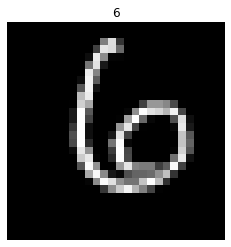

In [ ]:
#загрузка данных и показ 100 по счётц цифры из массива для обучения
train_dl, test_dl = prepare_data(path, img_show=True, num=100)

In [ ]:
#вызов модели
model = CNN(1)
#структура сети
print(model)

CNN(
  (hidden1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (hidden2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (hidden3): Linear(in_features=800, out_features=100, bias=True)
  (act3): ReLU()
  (hidden4): Linear(in_features=100, out_features=10, bias=True)
  (act4): Softmax(dim=1)
)


In [ ]:
#обучение сети с параметром сохранения параметров в файл
train_model(train_dl, model, save_model=True)

Эпоха: 1 [29984/60000 (100%)]	Потери: 1.677490
Эпоха: 2 [29984/60000 (100%)]	Потери: 1.583595
Эпоха: 3 [29984/60000 (100%)]	Потери: 1.494003
Эпоха: 4 [29984/60000 (100%)]	Потери: 1.468855
Эпоха: 5 [29984/60000 (100%)]	Потери: 1.466141
Эпоха: 6 [29984/60000 (100%)]	Потери: 1.504125
Эпоха: 7 [29984/60000 (100%)]	Потери: 1.530418
Эпоха: 8 [29984/60000 (100%)]	Потери: 1.461969
Эпоха: 9 [29984/60000 (100%)]	Потери: 1.461176
Эпоха: 10 [29984/60000 (100%)]	Потери: 1.461217
Сохранение весов модели в файл


In [ ]:
#проверка точности
acc = evaluate_model(test_dl,model)
print('Accuracy: {}'.format(acc))

Accuracy: 0.9884


В Paint от руки были написаны цифры от 0 до 9, которыми была совершена итоговая проверка модели

In [ ]:
#преобразование изображения, на вход принимает путь до картинка
def get_image(path_img):
  img = Image.open(path_img)
  img = img.convert('L')
  img = ImageOps.invert(img)
  img = np.array(img).astype('float32')/256
  return img

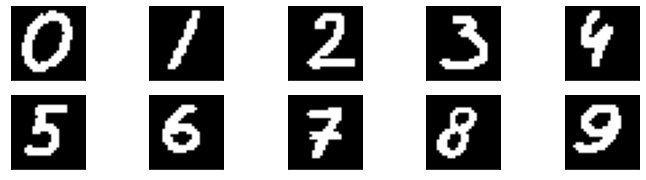

In [ ]:
#через цикл выведены все изображения
fig = plt.figure(figsize = (12, 3))
for i in range(10):
  ax = fig.add_subplot(2, 5, i + 1, xticks = [], yticks = [])
  image = get_image(r"img_"+str(i)+".png")
  plt.imshow(image, cmap='gray')

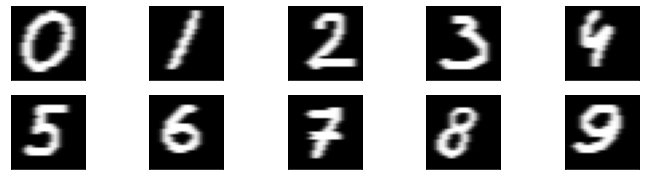

In [ ]:
#применение функции сглаживания для границ цифр
fig = plt.figure(figsize = (12, 3))
arr_test = list()
for i in range(10):
  ax = fig.add_subplot(2, 5, i + 1, xticks = [], yticks = [])
  image = get_image(r"img_"+str(i)+".png")
  test_img = gaussian_filter1d(np.array(image), sigma=1)
  arr_test.append(test_img)
  ax.imshow(test_img, cmap='gray')

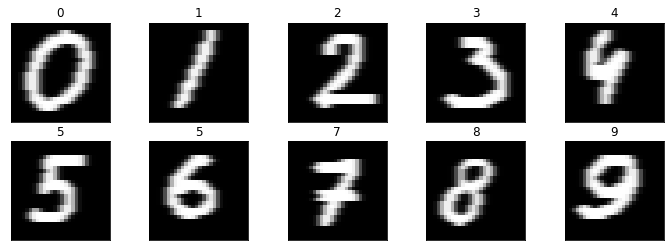

In [ ]:
#предсказание сетью цифр
fig = plt.figure(figsize = (12, 4))
arr_test = list()
for i in range(10):
  ax = fig.add_subplot(2, 5, i + 1, xticks = [], yticks = [])
  image = get_image(r"img_"+str(i)+".png")
  test_img = gaussian_filter1d(np.array(image), sigma=1)
  y_pred = predict(test_img,model)
  ax.imshow(test_img, cmap='gray')
  ax.set_title(y_pred)

Итог: обученная сеть правильно предсказала все цифры кроме цифры 6. Предположительно, это произошло из-за области, выделенной красным

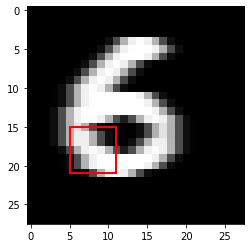

In [ ]:
img_6 = get_image('img_6.png')
img_6 = gaussian_filter1d(np.array(img_6), sigma=1)
plt.imshow(img_6, cmap='gray')
ax = plt.gca()
rect = patches.Rectangle((5,15),
                 6,
                 6,
                 linewidth=2,
                 edgecolor='red',
                 fill = False)
ax.add_patch(rect)
plt.show()

Также стоит отметить, что данная сеть, написанная с помощью PyTorch лучше, чем сеть, написанная с помощью Keras в прошлой работе. Для сранвнения, `acc_torch = 0.98, acc_ker = 0.94`